# Series De Tiempo

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error


c:\Users\rodri\Documents\Data Science\Lab1-DataScience\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Carga de Datos

In [5]:


# --- Carga de datos CSV ---
# Dataset 1: Nacimientos diarios
births = pd.read_csv("Data/daily-total-female-births.csv", parse_dates=["Date"])

# Dataset 2: Ventas mensuales de shampoo
shampoo = pd.read_csv("Data/shampoo.csv")
shampoo["Month"] = pd.date_range(start="1901-01", periods=len(shampoo), freq="M")



C:\Users\rodri\AppData\Local\Temp\ipykernel_4736\1788292830.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  shampoo["Month"] = pd.date_range(start="1901-01", periods=len(shampoo), freq="M")


In [6]:
dft = pd.read_csv("Data/monthly-mean-temp.csv")
dft["Month"] = pd.to_datetime(dft["Month"])
dft = dft.sort_values(by="Month")
dft.set_index("Month", inplace=True)

dfc = pd.read_csv("Data/monthly-car-sales.csv")
dfc["Month"] = pd.to_datetime(dfc["Month"])
dfc = dfc.sort_values(by="Month")
dfc.set_index("Month", inplace=True)


## EDA

In [7]:
import tensorflow as tf

tf.random.set_seed(123)
dateparse = lambda dates: pd.datetime.strptime(x, "%Y-%m")
print("Monthly mean temperature")
print(dft.head())
print(dft.tail())
print("Monthly car sales")
print(dfc.head())
print(dfc.tail())

Monthly mean temperature
            Temperature
Month                  
1920-01-01         40.6
1920-02-01         40.8
1920-03-01         44.4
1920-04-01         46.7
1920-05-01         54.1
            Temperature
Month                  
1939-08-01         61.8
1939-09-01         58.2
1939-10-01         46.7
1939-11-01         46.6
1939-12-01         37.8
Monthly car sales
            Sales
Month            
1960-01-01   6550
1960-02-01   8728
1960-03-01  12026
1960-04-01  14395
1960-05-01  14587
            Sales
Month            
1968-08-01  16722
1968-09-01  14385
1968-10-01  21342
1968-11-01  17180
1968-12-01  14577


## Gráficos de las series 

#### Nacimientos 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Births  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB
Nacimientos diarios:
 None


Text(0, 0.5, 'Cantidad')

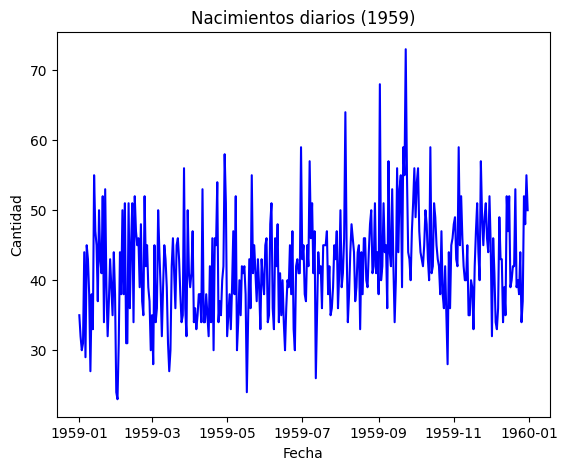

In [8]:
plt.figure(figsize=(14, 5))



# --- Información General ---# Nacimientos
print("Nacimientos diarios:\n", births.info())
plt.subplot(1, 2, 1)
plt.plot(births["Date"], births["Births"], color="blue")
plt.title("Nacimientos diarios (1959)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")



#### Ventas de Shampoos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   36 non-null     datetime64[ns]
 1   Sales   36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 704.0 bytes

Shampoo:
 None


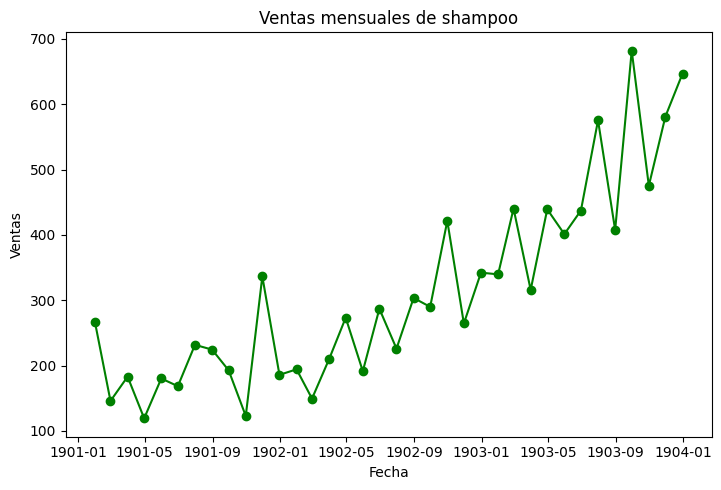

In [9]:
plt.figure(figsize=(14, 5))



# Ventas Shampoo
print("\nShampoo:\n", shampoo.info())

plt.subplot(1, 2, 2)
plt.plot(shampoo["Month"], shampoo["Sales"], marker="o", color="green")
plt.title("Ventas mensuales de shampoo")
plt.xlabel("Fecha")
plt.ylabel("Ventas")

plt.tight_layout()
plt.show()


#### Temperatura 

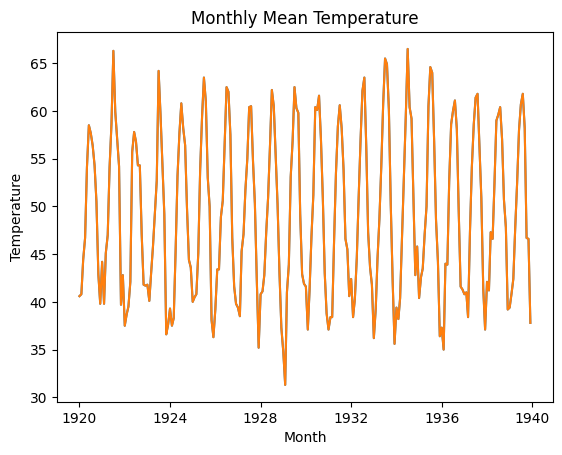

In [10]:
plt.plot(dft)
plt.plot(dft)
plt.gca().set(title='Monthly Mean Temperature', xlabel='Month', ylabel='Temperature')
plt.show()




#### Ventas de autos

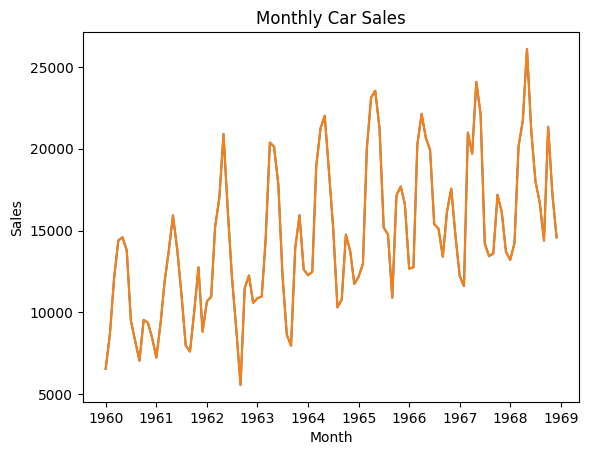

In [11]:
plt.plot(dfc)
plt.plot(dfc)
plt.gca().set(title='Monthly Car Sales', xlabel='Month', ylabel='Sales')
plt.show()

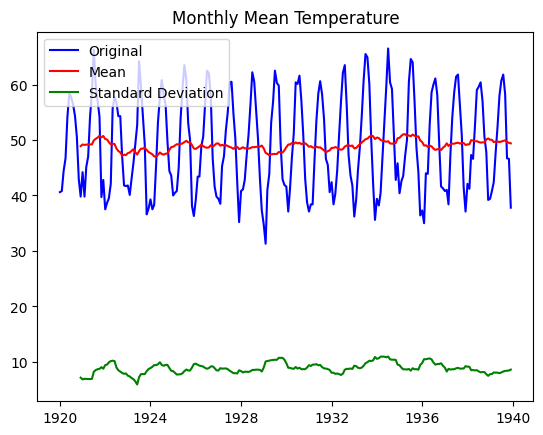

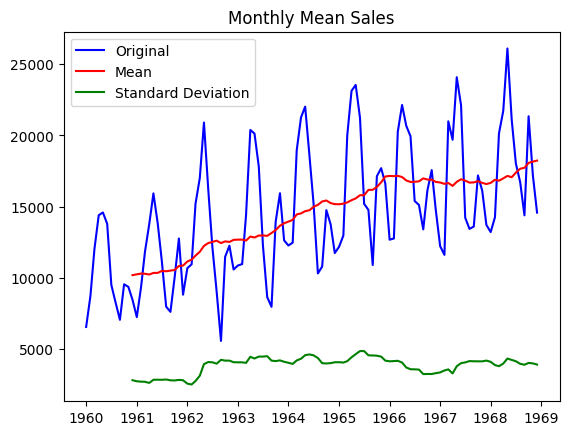

In [12]:
movmeant= dft.rolling(window=12).mean()
movmeanc=dfc.rolling(window=12).mean()

ddft=dft.rolling(window=12).std()
ddc=dfc.rolling(window=12).std()

originalt = plt.plot(dft, color='blue', label='Original')
meant = plt.plot(movmeant, color='red', label='Mean')
stdt = plt.plot(ddft, color='green', label='Standard Deviation')
plt.legend()
plt.title('Monthly Mean Temperature')
plt.show()

originalc = plt.plot(dfc, color='blue', label='Original')
meanc = plt.plot(movmeanc, color='red', label='Mean')
stdc = plt.plot(ddc, color='green', label='Standard Deviation')
plt.legend()
plt.title('Monthly Mean Sales')
plt.show()


---

##### 1. Nacimientos diarios (1959)
- **Tipo de serie:** Frecuencia diaria.
- **Patrón:** Muy variable, con picos frecuentes.
- **Tendencia:** No evidente.
- **Estacionalidad:** No clara, pero podría existir algún ciclo semanal (requiere análisis específico).
- **Ruido:** Muy alto; la serie es ruidosa y dispersa.

---

##### 2. Ventas mensuales de shampoo
- **Tipo de serie:** Mensual, 3 años.
- **Patrón:** Tendencia creciente clara.
- **Estacionalidad:** Indicios de estacionalidad, pero difícil de afirmar por corto historial.
- **Ruido:** Moderado; las subidas/bajadas siguen la tendencia general.

---

##### 3. Temperaturas mensuales medias
- **Tipo de serie:** Mensual, 20 años.
- **Patrón:** Ciclos regulares muy marcados.
- **Tendencia:** No aparente; la media es casi constante.
- **Estacionalidad:** Muy fuerte .
- **Ruido:** Bajo.

---

##### 4. Ventas mensuales de autos
- **Tipo de serie:** Mensual, casi 9 años.
- **Patrón:** Tendencia creciente clara, con ciclos.
- **Tendencia:** Aumenta de manera evidente.
- **Estacionalidad:** Fuerte; ciclos anuales muy claros.
- **Ruido:** Moderado.


### Partición de datos

In [21]:
print(births.columns)


Index(['Births'], dtype='object')


In [23]:
import pandas as pd

# Asegúrate de tener el índice como datetime
dft.index = pd.to_datetime(dft.index)
dfc.index = pd.to_datetime(dfc.index)
import pandas as pd

# Nacimientos diarios
births = pd.read_csv("Data/daily-total-female-births.csv")
births['Date'] = pd.to_datetime(births['Date'])
births.set_index('Date', inplace=True)

# Ventas de shampoo mensual
shampoo = pd.read_csv("Data/shampoo.csv")

shampoo['Year'] = shampoo['Month'].str.split('-').str[0].astype(int)
shampoo['MonthNum'] = shampoo['Month'].str.split('-').str[1].astype(int)
shampoo['Date'] = pd.to_datetime({'year': 1900 + shampoo['Year'], 'month': shampoo['MonthNum'], 'day': 1})
shampoo.set_index('Date', inplace=True)


# --- SPLIT POR FECHA: último año como test ---
# Para temperatura
split_t = '1939-01-01'
train_t = dft[dft.index < split_t].copy()
test_t  = dft[dft.index >= split_t].copy()

# Para ventas de autos
split_c = '1968-01-01'
train_c = dfc[dfc.index < split_c].copy()
test_c  = dfc[dfc.index >= split_c].copy()

# Nacimientos
split_b = int(len(births) * 0.8)
train_b = births.iloc[:split_b]
test_b = births.iloc[split_b:]

# Shampoo
split_s = int(len(shampoo) * 0.8)
train_s = shampoo.iloc[:split_s]
test_s = shampoo.iloc[split_s:]


# Información de temperatura
print('Temperatura:')
print(f'  Tamaño train: {len(train_t)}')
print(f'  Tamaño test : {len(test_t)}')
print(f'  Periodo de entrenamiento: {train_t.index[0].date()} - {train_t.index[-1].date()}')
print(f'  Periodo de test         : {test_t.index[0].date()} - {test_t.index[-1].date()}')
print()

# Información de ventas de autos
print('Ventas de autos:')
print(f'  Tamaño train: {len(train_c)}')
print(f'  Tamaño test : {len(test_c)}')
print(f'  Periodo de entrenamiento: {train_c.index[0].date()} - {train_c.index[-1].date()}')
print(f'  Periodo de test         : {test_c.index[0].date()} - {test_c.index[-1].date()}')

# Información de nacimientos
print('Nacimientos:')
print(f'  Tamaño train: {len(train_b)}')
print(f'  Tamaño test : {len(test_b)}')
print(f'  Periodo de entrenamiento: {train_b.index[0].date()} - {train_b.index[-1].date()}')
print(f'  Periodo de test         : {test_b.index[0].date()} - {test_b.index[-1].date()}')

# Información de shampoo
print('Shampoo:')
print(f'  Tamaño train: {len(train_s)}')
print(f'  Tamaño test : {len(test_s)}')
print(f'  Periodo de entrenamiento: {train_s.index[0].date()} - {train_s.index[-1].date()}')
print(f'  Periodo de test         : {test_s.index[0].date()} - {test_s.index[-1].date()}')

Temperatura:
  Tamaño train: 228
  Tamaño test : 12
  Periodo de entrenamiento: 1920-01-01 - 1938-12-01
  Periodo de test         : 1939-01-01 - 1939-12-01

Ventas de autos:
  Tamaño train: 96
  Tamaño test : 12
  Periodo de entrenamiento: 1960-01-01 - 1967-12-01
  Periodo de test         : 1968-01-01 - 1968-12-01
Nacimientos:
  Tamaño train: 292
  Tamaño test : 73
  Periodo de entrenamiento: 1959-01-01 - 1959-10-19
  Periodo de test         : 1959-10-20 - 1959-12-31
Shampoo:
  Tamaño train: 28
  Tamaño test : 8
  Periodo de entrenamiento: 1901-01-01 - 1903-04-01
  Periodo de test         : 1903-05-01 - 1903-12-01


### Predicción con Medias Móviles

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def moving_average_forecast(train, test, window):
    history = list(train)
    preds = []
    for t in range(len(test)):
        if len(history) < window:
            pred = np.mean(history)
        else:
            pred = np.mean(history[-window:])
        preds.append(pred)
        history.append(test[t])
    return np.array(preds)

def best_n_ma(y_train, y_test, windows, n=3):
    results = []
    for w in windows:
        preds = moving_average_forecast(y_train, y_test, w)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        results.append({'window': w, 'MAE': mae, 'RMSE': rmse, 'preds': preds})
    return sorted(results, key=lambda x: x['RMSE'])[:n]  # top-n

# Define rangos de ventanas
windows_births   = range(2, 20)
windows_shampoo  = range(2, 8)
windows_temp     = range(2, 16)
windows_cars     = range(2, 16)

# Calcula top 3 por cada conjunto
top3_b = best_n_ma(y_train_b, y_test_b, windows_births, n=3)
top3_s = best_n_ma(y_train_s, y_test_s, windows_shampoo, n=3)
top3_t = best_n_ma(y_train_t, y_test_t, windows_temp, n=3)
top3_c = best_n_ma(y_train_c, y_test_c, windows_cars, n=3)


In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def moving_average_forecast(train, test, window):
    history = list(train)
    preds = []
    for t in range(len(test)):
        if len(history) < window:
            pred = np.mean(history)
        else:
            pred = np.mean(history[-window:])
        preds.append(pred)
        history.append(test[t])
    return np.array(preds)

def best_n_ma(y_train, y_test, windows, n=3):
    results = []
    for w in windows:
        preds = moving_average_forecast(y_train, y_test, w)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        results.append({'window': w, 'MAE': mae, 'RMSE': rmse, 'preds': preds})
    return sorted(results, key=lambda x: x['RMSE'])[:n]  # top-n

# Define rangos de ventanas
windows_births   = range(2, 20)
windows_shampoo  = range(2, 8)
windows_temp     = range(2, 16)
windows_cars     = range(2, 16)

# Calcula top 3 por cada conjunto
top3_b = best_n_ma(y_train_b, y_test_b, windows_births, n=3)
top3_s = best_n_ma(y_train_s, y_test_s, windows_shampoo, n=3)
top3_t = best_n_ma(y_train_t, y_test_t, windows_temp, n=3)
top3_c = best_n_ma(y_train_c, y_test_c, windows_cars, n=3)



In [83]:
# Tabla de nacimientos
df_b = pd.DataFrame([{'Ventana': r['window'], 'MAE': r['MAE'], 'RMSE': r['RMSE']} for r in top3_b])
df_b['Conjunto'] = 'Nacimientos'
print(df_b)

# Shampoo
df_s = pd.DataFrame([{'Ventana': r['window'], 'MAE': r['MAE'], 'RMSE': r['RMSE']} for r in top3_s])
df_s['Conjunto'] = 'Shampoo'
print(df_s)

# Temperatura
df_t = pd.DataFrame([{'Ventana': r['window'], 'MAE': r['MAE'], 'RMSE': r['RMSE']} for r in top3_t])
df_t['Conjunto'] = 'Temperatura'
print(df_t)

# Autos
df_c = pd.DataFrame([{'Ventana': r['window'], 'MAE': r['MAE'], 'RMSE': r['RMSE']} for r in top3_c])
df_c['Conjunto'] = 'Autos'
print(df_c)




   Ventana       MAE      RMSE     Conjunto
0        4  5.619863  6.648785  Nacimientos
1        5  5.684932  6.710001  Nacimientos
2        3  5.552511  6.712400  Nacimientos
   Ventana        MAE        RMSE Conjunto
0        3  85.404167  104.313223  Shampoo
1        2  84.625000  106.173608  Shampoo
2        5  86.790000  112.132770  Shampoo
   Ventana       MAE      RMSE     Conjunto
0        2  5.691667  6.537998  Temperatura
1       14  6.951786  7.648630  Temperatura
2       15  6.996667  7.709130  Temperatura
   Ventana          MAE         RMSE Conjunto
0       13  3164.423077  3842.464042    Autos
1       14  3149.488095  3851.132976    Autos
2       12  3331.493056  3971.242814    Autos


#### Graficos

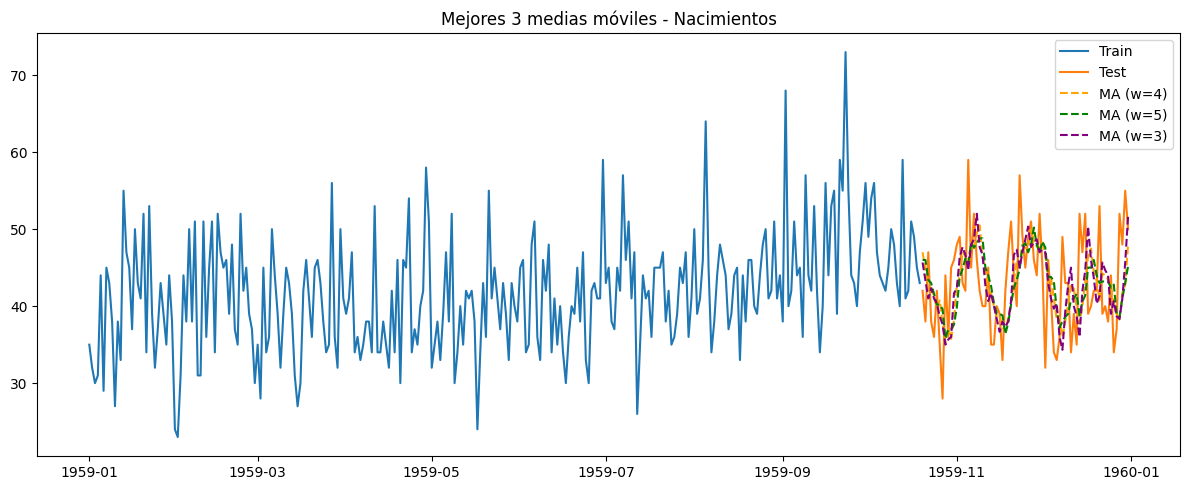

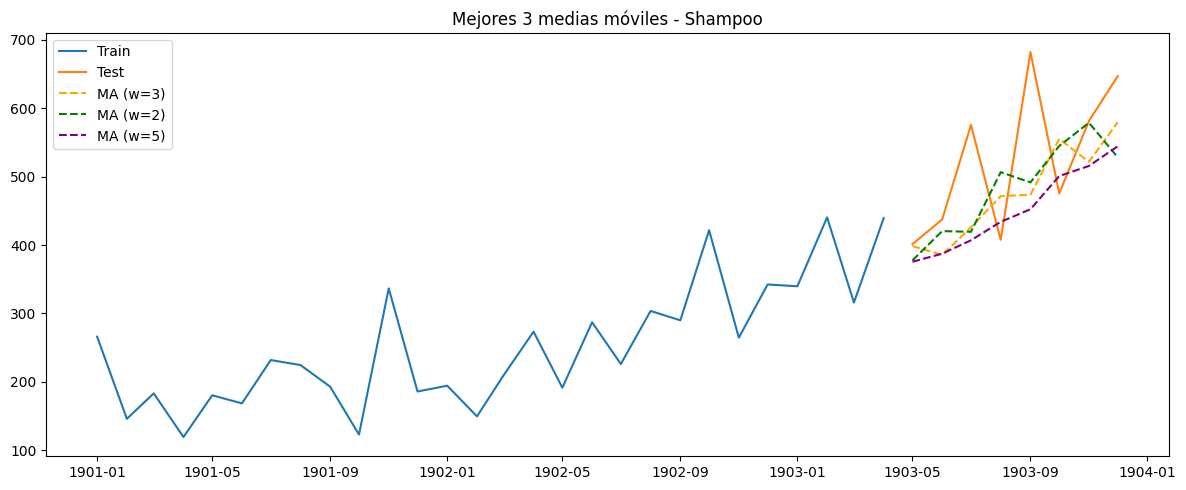

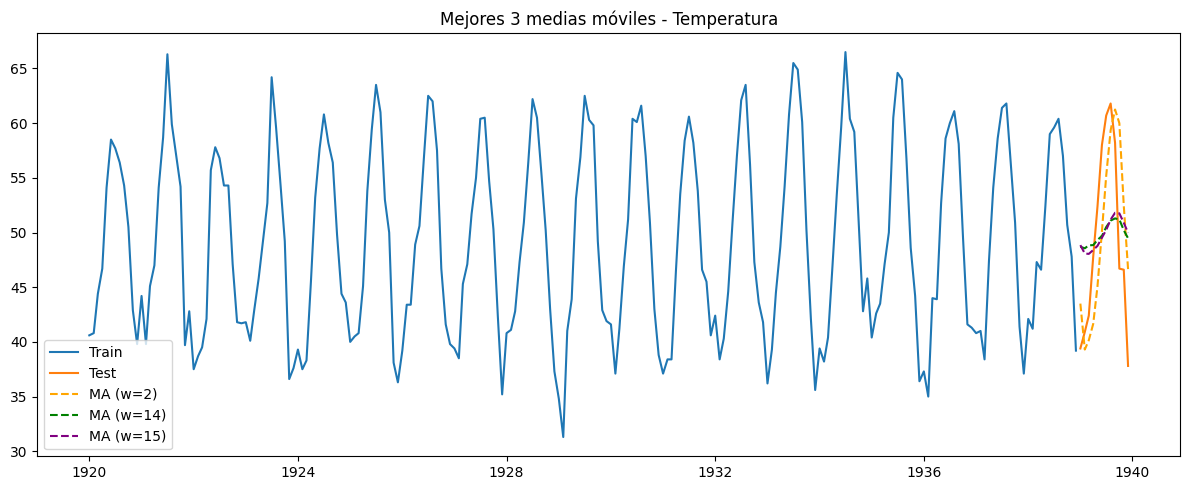

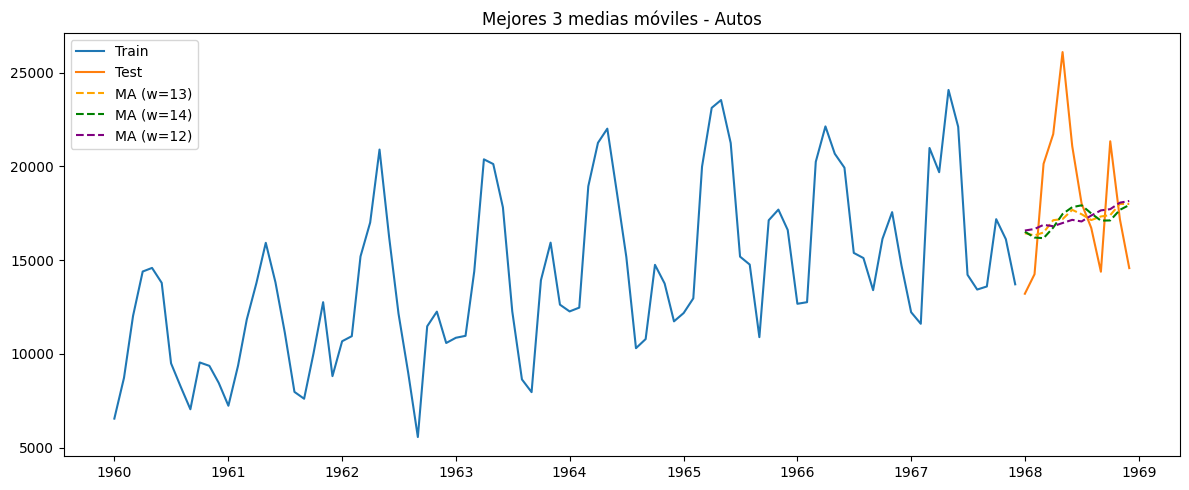

In [84]:
def plot_top3_ma(y_train, y_test, train_idx, test_idx, top3, conjunto):
    plt.figure(figsize=(12,5))
    plt.plot(train_idx, y_train, label='Train')
    plt.plot(test_idx, y_test, label='Test')
    colors = ['orange', 'green', 'purple']
    for i, res in enumerate(top3):
        plt.plot(test_idx, res['preds'], label=f'MA (w={res["window"]})', linestyle='--', color=colors[i])
    plt.title(f'Mejores 3 medias móviles - {conjunto}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_top3_ma(y_train_b, y_test_b, train_b.index, test_b.index, top3_b, 'Nacimientos')
plot_top3_ma(y_train_s, y_test_s, train_s.index, test_s.index, top3_s, 'Shampoo')
plot_top3_ma(y_train_t, y_test_t, train_t.index, test_t.index, top3_t, 'Temperatura')
plot_top3_ma(y_train_c, y_test_c, train_c.index, test_c.index, top3_c, 'Autos')




##### 1. Nacimientos diarios (1959)
- **Mejores ventanas:** 3, 4 y 5.
- **MAE:** ≈5.6 | **RMSE:** ≈6.7
- **Interpretación:**  
  Todos los tamaños de ventana ofrecen resultados similares porque la serie es muy ruidosa y no tiene patrones claros. El error relativamente alto refleja que la media móvil no puede anticipar los picos y caídas repentinas.  
  **Conclusión:** Para series dominadas por el azar, la MA apenas suaviza pero no predice.

---

##### 2. Ventas mensuales de shampoo
- **Mejores ventanas:** 2, 3 y 5.
- **MAE:** ≈85 | **RMSE:** ≈106–112
- **Interpretación:**  
  Los errores son altos porque la media móvil no logra seguir la tendencia creciente de las ventas, siempre se queda por debajo. Las diferencias entre ventanas son mínimas, pero todas subestiman el valor real.
  **Conclusión:** MA es poco útil para forecasting en series con tendencia fuerte.

---

### 3. Temperatura mensual
- **Mejores ventanas:** 2, 14 y 15.
- **MAE:** ≈5.7–7.0 | **RMSE:** ≈6.5–7.7
- **Interpretación:**  
  Ventanas pequeñas capturan mejor las subidas y bajadas rápidas, pero en general MA no logra seguir el ciclo estacional correctamente. Los errores aumentan al usar ventanas largas porque se pierde el patrón.
  **Conclusión:** MA no es adecuada cuando predomina la estacionalidad.

---

### 4. Ventas mensuales de autos
- **Mejores ventanas:** 12, 13 y 14.
- **MAE:** ≈3150–3330 | **RMSE:** ≈3840–3970
- **Interpretación:**  
  Las ventanas grandes reflejan que se intenta capturar el ciclo anual, pero la predicción resulta demasiado "promediada" y los picos/valles se pierden. El error es alto porque la serie combina tendencia y estacionalidad.
  **Conclusión:** MA falla en series con patrones complejos; no predice bien ni tendencia ni ciclos.

---

**Resumen general:**  
Las métricas MAE y RMSE confirman que la media móvil solo es útil en series simples y ruidosas, pero su predicción es muy limitada en presencia de tendencia y/o estacionalidad. Otros modelos más sofisticados serán necesarios para mejorar el desempeño.

### Aislamiento Exponencial Simple

In [85]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def best_n_ses(y_train, y_test, alphas, n=3):
    results = []
    for alpha in alphas:
        model = SimpleExpSmoothing(y_train).fit(smoothing_level=alpha, optimized=False)
        preds = model.forecast(len(y_test))
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        results.append({'alpha': alpha, 'MAE': mae, 'RMSE': rmse, 'preds': preds})
    return sorted(results, key=lambda x: x['RMSE'])[:n]  # top-n


In [86]:
# Rango amplio de alphas (puedes afinar después)
alphas = np.linspace(0.01, 0.99, 20)

# Top 3 para cada conjunto
top3_ses_b = best_n_ses(y_train_b, y_test_b, alphas, n=3)
top3_ses_s = best_n_ses(y_train_s, y_test_s, alphas, n=3)
top3_ses_t = best_n_ses(y_train_t, y_test_t, alphas, n=3)
top3_ses_c = best_n_ses(y_train_c, y_test_c, alphas, n=3)


In [88]:
# Nacimientos
df_ses_b = pd.DataFrame([{'Alpha': r['alpha'], 'MAE': r['MAE'], 'RMSE': r['RMSE']} for r in top3_ses_b])
df_ses_b['Conjunto'] = 'Nacimientos'
print(df_ses_b)

# Shampoo
df_ses_s = pd.DataFrame([{'Alpha': r['alpha'], 'MAE': r['MAE'], 'RMSE': r['RMSE']} for r in top3_ses_s])
df_ses_s['Conjunto'] = 'Shampoo'
print(df_ses_s)

# Temperatura
df_ses_t = pd.DataFrame([{'Alpha': r['alpha'], 'MAE': r['MAE'], 'RMSE': r['RMSE']} for r in top3_ses_t])
df_ses_t['Conjunto'] = 'Temperatura'
print(df_ses_t)

# Autos
df_ses_c = pd.DataFrame([{'Alpha': r['alpha'], 'MAE': r['MAE'], 'RMSE': r['RMSE']} for r in top3_ses_c])
df_ses_c['Conjunto'] = 'Autos'
print(df_ses_c)



      Alpha       MAE      RMSE     Conjunto
0  0.990000  5.234274  6.423361  Nacimientos
1  0.938421  5.242374  6.424321  Nacimientos
2  0.886842  5.251984  6.428282  Nacimientos
      Alpha         MAE        RMSE Conjunto
0  0.990000  104.817913  135.170676  Shampoo
1  0.938421  107.612640  139.096127  Shampoo
2  0.886842  110.295563  142.768197  Shampoo
      Alpha       MAE      RMSE     Conjunto
0  0.216316  7.385643  8.244720  Temperatura
1  0.267895  7.281423  8.255367  Temperatura
2  0.061579  7.454459  8.263661  Temperatura
      Alpha          MAE         RMSE Conjunto
0  0.113158  3389.882129  4209.606327    Autos
1  0.061579  3398.085510  4220.915888    Autos
2  0.164737  3463.172454  4314.574106    Autos


#### Graficos

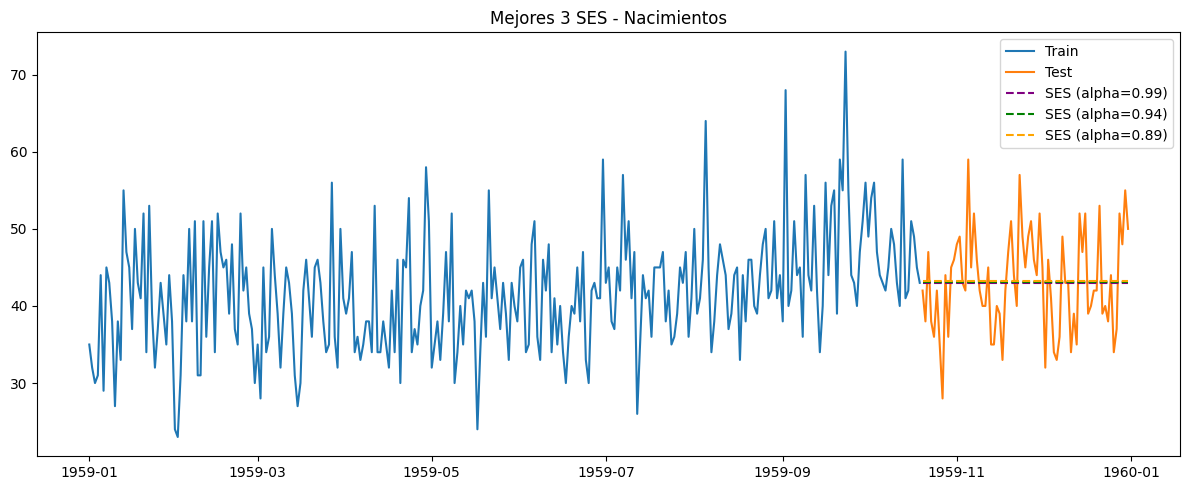

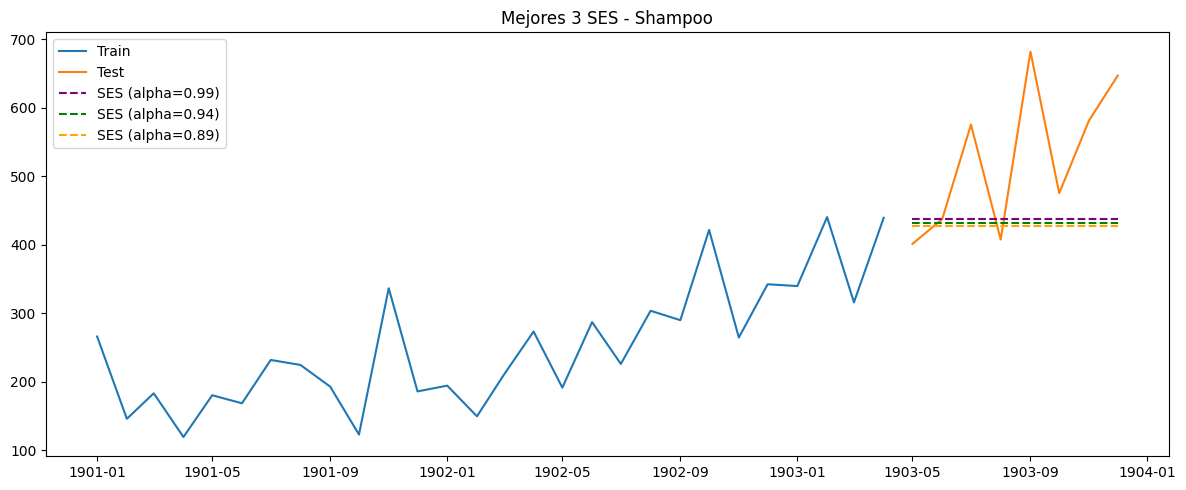

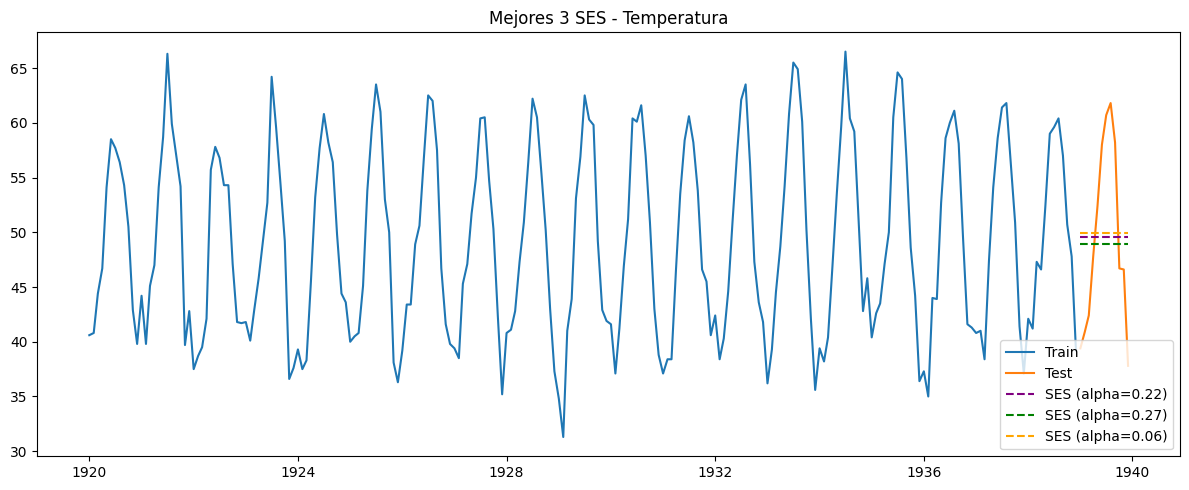

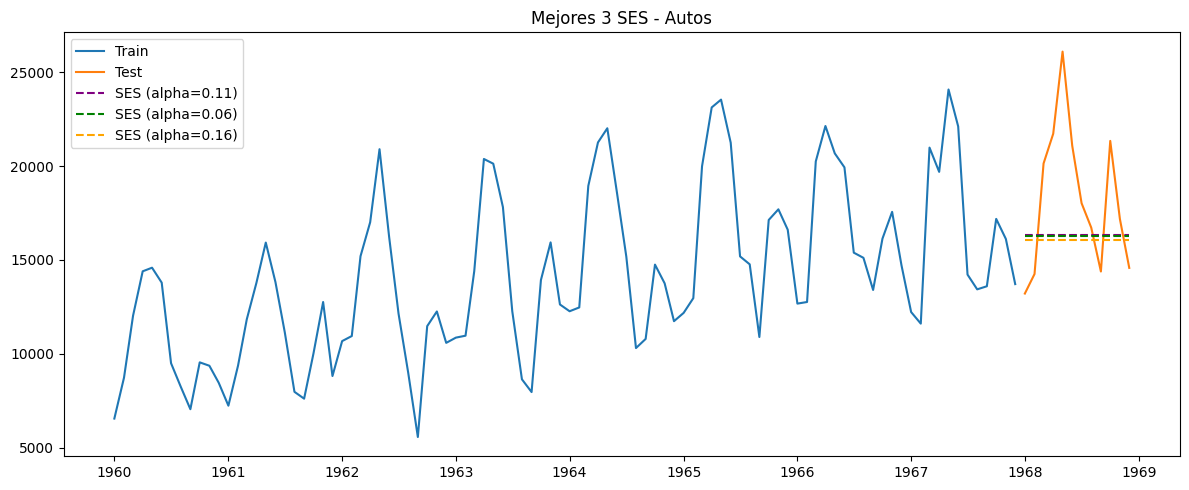

In [89]:
def plot_top3_ses(y_train, y_test, train_idx, test_idx, top3, conjunto):
    plt.figure(figsize=(12,5))
    plt.plot(train_idx, y_train, label='Train')
    plt.plot(test_idx, y_test, label='Test')
    colors = ['purple', 'green', 'orange']
    for i, res in enumerate(top3):
        plt.plot(test_idx, res['preds'], label=f'SES (alpha={res["alpha"]:.2f})', linestyle='--', color=colors[i])
    plt.title(f'Mejores 3 SES - {conjunto}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_top3_ses(y_train_b, y_test_b, train_b.index, test_b.index, top3_ses_b, 'Nacimientos')
plot_top3_ses(y_train_s, y_test_s, train_s.index, test_s.index, top3_ses_s, 'Shampoo')
plot_top3_ses(y_train_t, y_test_t, train_t.index, test_t.index, top3_ses_t, 'Temperatura')
plot_top3_ses(y_train_c, y_test_c, train_c.index, test_c.index, top3_ses_c, 'Autos')



##### 1. Nacimientos diarios (1959)
- **Mejores alphas:** 0.99, 0.94, 0.89.
- **MAE:** ≈5.2 | **RMSE:** ≈6.4
- **Interpretación:**  
  Valores altos de α hacen que SES reaccione rápido a los cambios recientes, lo cual es útil en series muy ruidosas como esta. Sin embargo, SES solo logra ajustar el promedio local, sin anticipar los picos y valles.
- **Conclusión:**  
  SES suaviza el ruido, pero su capacidad predictiva sigue siendo limitada en series dominadas por el azar. Pequeña mejora respecto a MA.

---

##### 2. Ventas mensuales de shampoo
- **Mejores alphas:** 0.99, 0.94, 0.89.
- **MAE:** ≈105–110 | **RMSE:** ≈135–143
- **Interpretación:**  
  SES tiende a quedarse rezagado y no logra anticipar el crecimiento de la serie. Aunque α alto permite adaptarse más rápido, la tendencia no se modela explícitamente, por lo que el error sigue siendo alto y comparable o incluso mayor que el de MA.
- **Conclusión:**  
  SES no es adecuado para series con tendencia; el método subestima los valores reales.

---

### 3. Temperatura mensual
- **Mejores alphas:** 0.22, 0.27, 0.06.
- **MAE:** ≈7.3–7.5 | **RMSE:** ≈8.2–8.3
- **Interpretación:**  
  α bajos suavizan mucho la serie, lo cual es típico en datos estacionales. Sin embargo, SES no logra capturar la estacionalidad fuerte y las predicciones terminan siendo promedios.
- **Conclusión:**  
  SES no es recomendable para series con ciclos estacionales, ya que no modela la periodicidad.

---

### 4. Ventas mensuales de autos
- **Mejores alphas:** 0.11, 0.06, 0.16.
- **MAE:** ≈3390–3460 | **RMSE:** ≈4210–4315
- **Interpretación:**  
  Igual que en temperatura, el SES promedia los valores y pierde la tendencia y la estacionalidad de la serie. El error es alto y las predicciones son poco realistas.
- **Conclusión:**  
  SES es insuficiente para series con tendencia y estacionalidad. Mejor usar modelos más avanzados.

---

**Resumen general:**  
El Alisamiento Exponencial Simple (SES) solo es útil para series estacionarias y sin tendencia ni estacionalidad. Cuando la serie muestra tendencia o ciclos, el desempeño del SES es pobre y el error es alto, como lo demuestran las métricas MAE y RMSE.


### HOLT-WINTERS

In [90]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

def best_n_hw(y_train, y_test, trends, seasonals, seasonal_periods, n=3):
    configs = list(itertools.product(trends, seasonals))
    results = []
    for trend, seasonal in configs:
        try:
            model = ExponentialSmoothing(
                y_train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods
            ).fit()
            preds = model.forecast(len(y_test))
            mae = mean_absolute_error(y_test, preds)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            results.append({
                'trend': trend, 
                'seasonal': seasonal, 
                'MAE': mae, 
                'RMSE': rmse, 
                'preds': preds
            })
        except Exception as e:
            continue
    # Top-n por RMSE
    return sorted(results, key=lambda x: x['RMSE'])[:n]


In [91]:
trends = [None, 'add', 'mul']
seasonals = ['add', 'mul']

# Nacimientos (período 7, semanal)
top3_hw_b = best_n_hw(y_train_b, y_test_b, trends, seasonals, seasonal_periods=7, n=3)
# Shampoo, Temperatura, Autos (período 12, mensual)
top3_hw_s = best_n_hw(y_train_s, y_test_s, trends, seasonals, seasonal_periods=12, n=3)
top3_hw_t = best_n_hw(y_train_t, y_test_t, trends, seasonals, seasonal_periods=12, n=3)
top3_hw_c = best_n_hw(y_train_c, y_test_c, trends, seasonals, seasonal_periods=12, n=3)


c:\Users\rodri\Documents\Data Science\Lab1-DataScience\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [93]:
def hw_table(top3, conjunto):
    return pd.DataFrame([
        {
            'Conjunto': conjunto,
            'Trend': x['trend'], 
            'Seasonal': x['seasonal'], 
            'MAE': x['MAE'], 
            'RMSE': x['RMSE']
        }
        for x in top3
    ])

df_hw_b = hw_table(top3_hw_b, "Nacimientos")
df_hw_s = hw_table(top3_hw_s, "Shampoo")
df_hw_t = hw_table(top3_hw_t, "Temperatura")
df_hw_c = hw_table(top3_hw_c, "Autos")

print(df_hw_b)
print(df_hw_s)
print(df_hw_t)
print(df_hw_c)


      Conjunto Trend Seasonal       MAE      RMSE
0  Nacimientos  None      add  6.569753  7.942348
1  Nacimientos  None      mul  6.663716  8.052192
2  Nacimientos   mul      mul  6.891227  8.330615
  Conjunto Trend Seasonal         MAE        RMSE
0  Shampoo   mul      add   90.444350  117.165604
1  Shampoo   mul      mul  100.164780  120.396899
2  Shampoo   add      add  132.945833  163.892562
      Conjunto Trend Seasonal       MAE      RMSE
0  Temperatura  None      add  1.523608  1.854091
1  Temperatura   add      add  1.526686  1.857516
2  Temperatura   mul      add  1.529274  1.860195
  Conjunto Trend Seasonal          MAE         RMSE
0    Autos   add      add  1324.976461  1691.011297
1    Autos   mul      add  1460.005285  1785.531839
2    Autos   add      mul  1474.743978  1844.264549


### Graficos

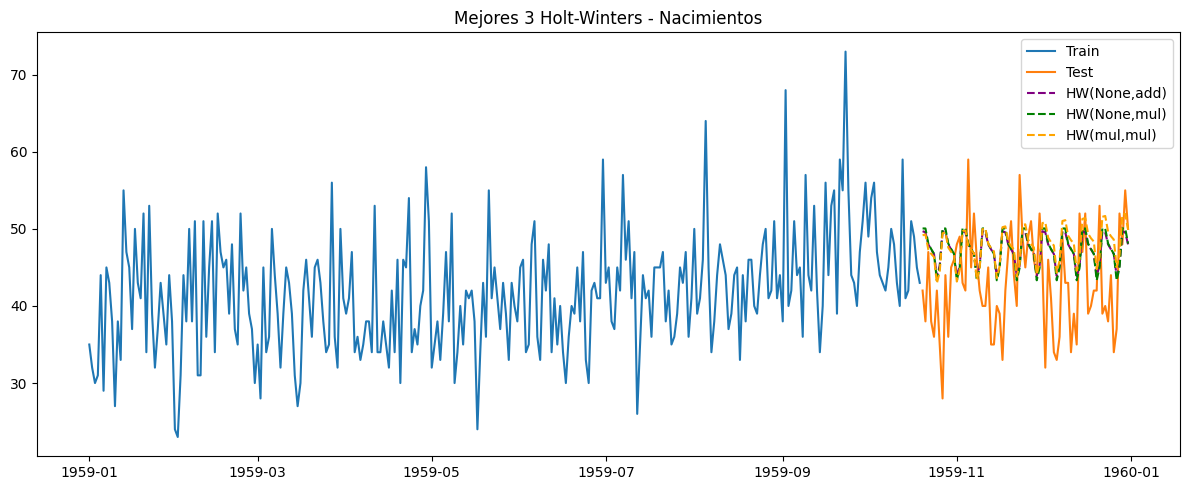

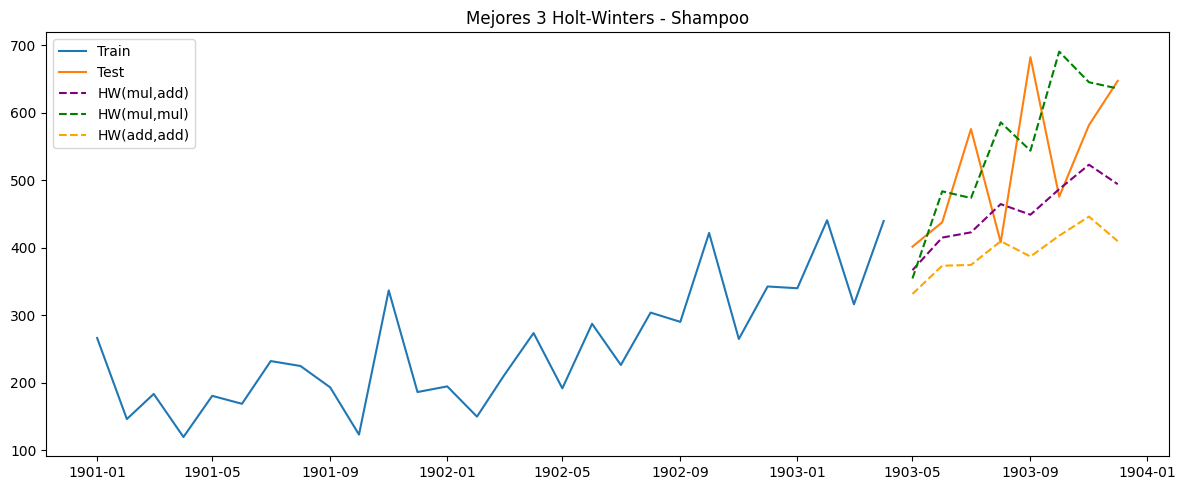

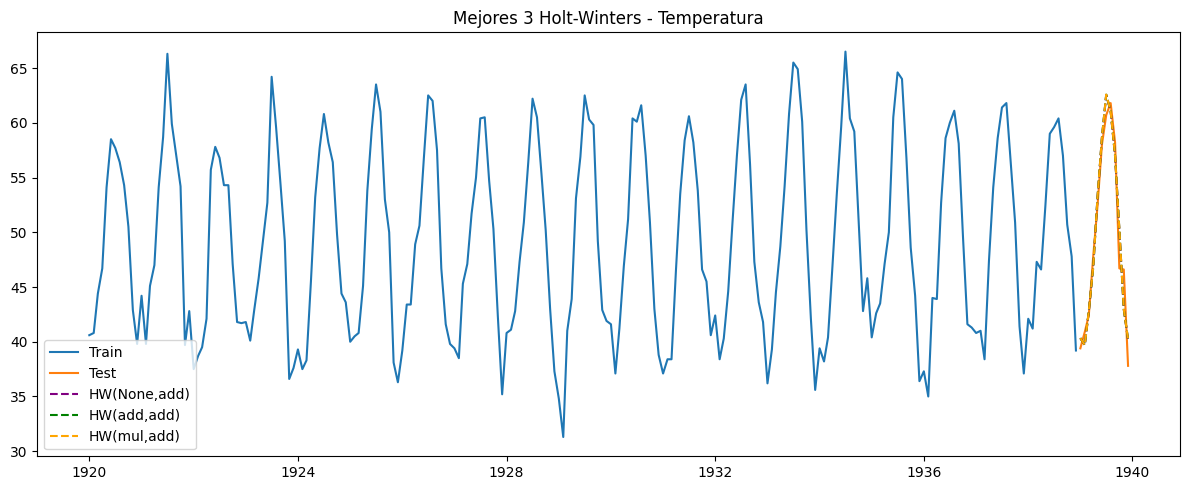

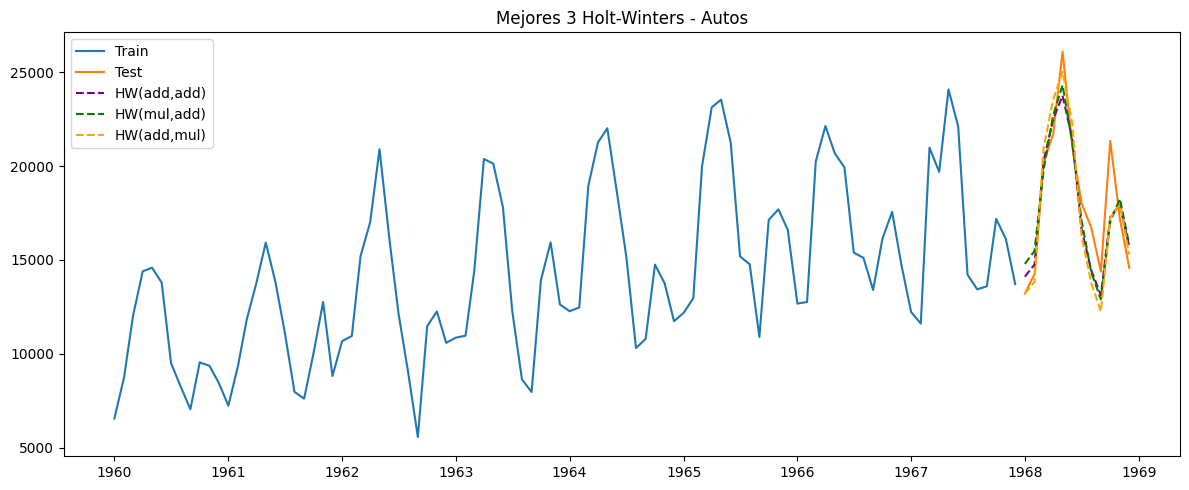

In [94]:
def plot_top3_hw(y_train, y_test, train_idx, test_idx, top3, conjunto):
    plt.figure(figsize=(12,5))
    plt.plot(train_idx, y_train, label='Train')
    plt.plot(test_idx, y_test, label='Test')
    colors = ['purple', 'green', 'orange']
    for i, res in enumerate(top3):
        plt.plot(test_idx, res['preds'], label=f"HW({res['trend']},{res['seasonal']})", linestyle='--', color=colors[i])
    plt.title(f'Mejores 3 Holt-Winters - {conjunto}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_top3_hw(y_train_b, y_test_b, train_b.index, test_b.index, top3_hw_b, 'Nacimientos')
plot_top3_hw(y_train_s, y_test_s, train_s.index, test_s.index, top3_hw_s, 'Shampoo')
plot_top3_hw(y_train_t, y_test_t, train_t.index, test_t.index, top3_hw_t, 'Temperatura')
plot_top3_hw(y_train_c, y_test_c, train_c.index, test_c.index, top3_hw_c, 'Autos')




##### 1. Nacimientos diarios (1959)
- **Mejores configuraciones:** HW(None, add), HW(None, mul), HW(mul, mul).
- **MAE:** ≈6.6 | **RMSE:** ≈8.0
- **Interpretación:**  
  La serie es principalmente ruido, sin estacionalidad ni tendencia clara. Holt-Winters no aporta mejora significativa; los errores son similares a los de métodos simples.  
  **Conclusión:**  
  HW no es eficiente en series dominadas por el azar, pero al menos mantiene el error acotado.

---

##### 2. Ventas mensuales de shampoo
- **Mejores configuraciones:** HW(mul, add), HW(mul, mul), HW(add, add).
- **MAE:** ≈90–133 | **RMSE:** ≈117–164
- **Interpretación:**  
  Con tendencia creciente y posible estacionalidad, HW mejora el ajuste respecto a métodos simples. Sin embargo, el rendimiento varía según la parametrización: modelos multiplicativos suelen captar mejor la dinámica cuando la tendencia es creciente y no lineal.  
  **Conclusión:**  
  HW es mejor que MA y SES para capturar tendencia y cierta estacionalidad, aunque la estacionalidad en este conjunto es débil.

---

##### 3. Temperatura mensual
- **Mejores configuraciones:** HW(None, add), HW(add, add), HW(mul, add).
- **MAE:** ≈1.5 | **RMSE:** ≈1.85
- **Interpretación:**  
  Aquí HW destaca claramente: los modelos con estacionalidad aditiva o multiplicativa logran un ajuste muy preciso, replicando los ciclos anuales. El error cae drásticamente respecto a MA o SES.
- **Conclusión:**  
  HW es ideal para series fuertemente estacionales; logra pronósticos precisos y realistas.

---

##### 4. Ventas mensuales de autos
- **Mejores configuraciones:** HW(add, add), HW(mul, add), HW(add, mul).
- **MAE:** ≈1325–1475 | **RMSE:** ≈1691–1844
- **Interpretación:**  
  HW se adapta bien tanto a la tendencia como a los ciclos, con errores sustancialmente menores respecto a modelos simples. Las variantes aditivas/multiplicativas logran pronósticos muy cercanos a los valores reales.
- **Conclusión:**  
  HW es muy efectivo en series con tendencia y estacionalidad combinadas; reduce el error y mejora la calidad del forecasting.

---

**Resumen general:**  
Holt-Winters sobresale en series con tendencia y/o estacionalidad. La elección entre aditivo y multiplicativo depende de la naturaleza de los ciclos y de la tendencia. **Cuando la serie es ruidosa y sin estructura, HW no aporta valor extra, pero en series estructuradas su desempeño es notablemente superior** según las métricas MAE y RMSE.


### SARIMA

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

def best_n_sarima(y_train, y_test, orders, seasonal_orders, n=3):
    results = []
    for order, sorder in itertools.product(orders, seasonal_orders):
        try:
            model = SARIMAX(y_train, order=order, seasonal_order=sorder).fit(disp=False)
            preds = model.forecast(len(y_test))
            mae = mean_absolute_error(y_test, preds)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            results.append({
                'order': order,
                'seasonal_order': sorder,
                'MAE': mae,
                'RMSE': rmse,
                'preds': preds
            })
        except Exception as e:
            continue
    return sorted(results, key=lambda x: x['RMSE'])[:n]


In [100]:
# Param grids
orders = [(1,1,1), (2,1,1), (1,1,0)]
seasonal_orders_b = [(0,0,0,0), (1,0,1,8)]      
seasonal_orders_m = [(0,0,0,0), (1,0,1,12)]     

# Nacimientos
top3_sarima_b = best_n_sarima(y_train_b, y_test_b, orders, seasonal_orders_b, n=3)
# Shampoo
top3_sarima_s = best_n_sarima(y_train_s, y_test_s, orders, seasonal_orders_m, n=3)
# Temperatura
top3_sarima_t = best_n_sarima(y_train_t, y_test_t, orders, seasonal_orders_m, n=3)
# Autos
top3_sarima_c = best_n_sarima(y_train_c, y_test_c, orders, seasonal_orders_m, n=3)


c:\Users\rodri\Documents\Data Science\Lab1-DataScience\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\rodri\Documents\Data Science\Lab1-DataScience\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\rodri\Documents\Data Science\Lab1-DataScience\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\rodri\Documents\Data Science\Lab1-DataScience\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax

In [102]:
def sarima_table(top3, conjunto):
    return pd.DataFrame([
        {
            'Conjunto': conjunto,
            'Order': x['order'],
            'Seasonal Order': x['seasonal_order'],
            'MAE': x['MAE'],
            'RMSE': x['RMSE']
        }
        for x in top3
    ])

df_sarima_b = sarima_table(top3_sarima_b, "Nacimientos")
df_sarima_s = sarima_table(top3_sarima_s, "Shampoo")
df_sarima_t = sarima_table(top3_sarima_t, "Temperatura")
df_sarima_c = sarima_table(top3_sarima_c, "Autos")

print(df_sarima_b)
print(df_sarima_s)
print(df_sarima_t)
print(df_sarima_c)


      Conjunto      Order Seasonal Order       MAE      RMSE
0  Nacimientos  (1, 1, 0)   (0, 0, 0, 0)  5.277395  6.450971
1  Nacimientos  (1, 1, 0)   (1, 0, 1, 8)  5.292795  6.463374
2  Nacimientos  (2, 1, 1)   (1, 0, 1, 8)  6.167289  7.482308
  Conjunto      Order Seasonal Order         MAE        RMSE
0  Shampoo  (1, 1, 0)   (0, 0, 0, 0)  140.266470  176.074770
1  Shampoo  (1, 1, 1)   (0, 0, 0, 0)  143.622118  176.118432
2  Shampoo  (2, 1, 1)   (0, 0, 0, 0)  145.772536  178.734144
      Conjunto      Order Seasonal Order        MAE       RMSE
0  Temperatura  (2, 1, 1)  (1, 0, 1, 12)   1.406789   1.702227
1  Temperatura  (1, 1, 0)  (1, 0, 1, 12)   1.664917   2.045179
2  Temperatura  (1, 1, 0)   (0, 0, 0, 0)  17.024504  19.163392
  Conjunto      Order Seasonal Order          MAE         RMSE
0    Autos  (2, 1, 1)  (1, 0, 1, 12)  1342.606277  1816.192199
1    Autos  (1, 1, 1)  (1, 0, 1, 12)  2196.704574  2623.475414
2    Autos  (1, 1, 0)  (1, 0, 1, 12)  2683.395590  3058.902071


### Gráficos

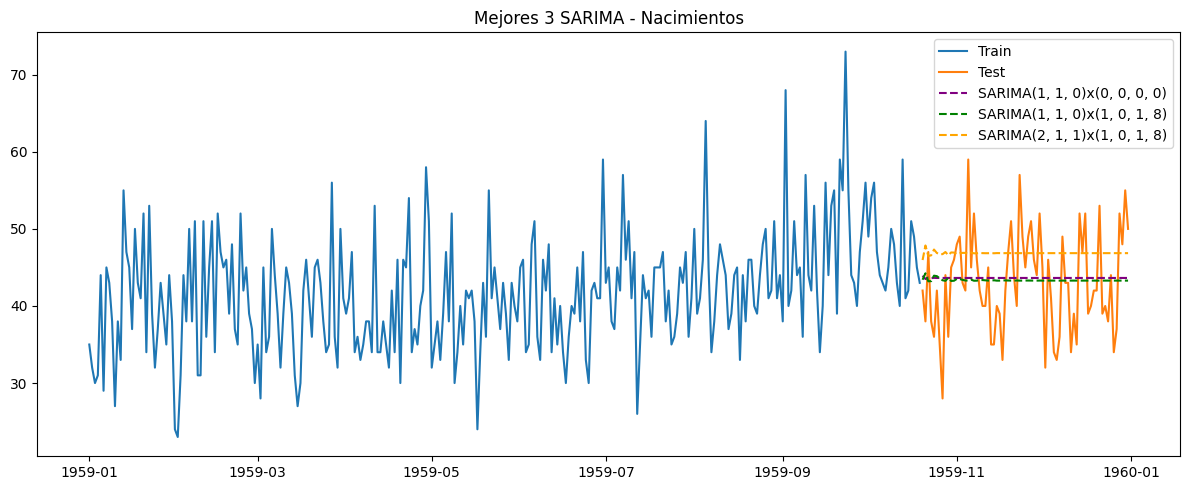

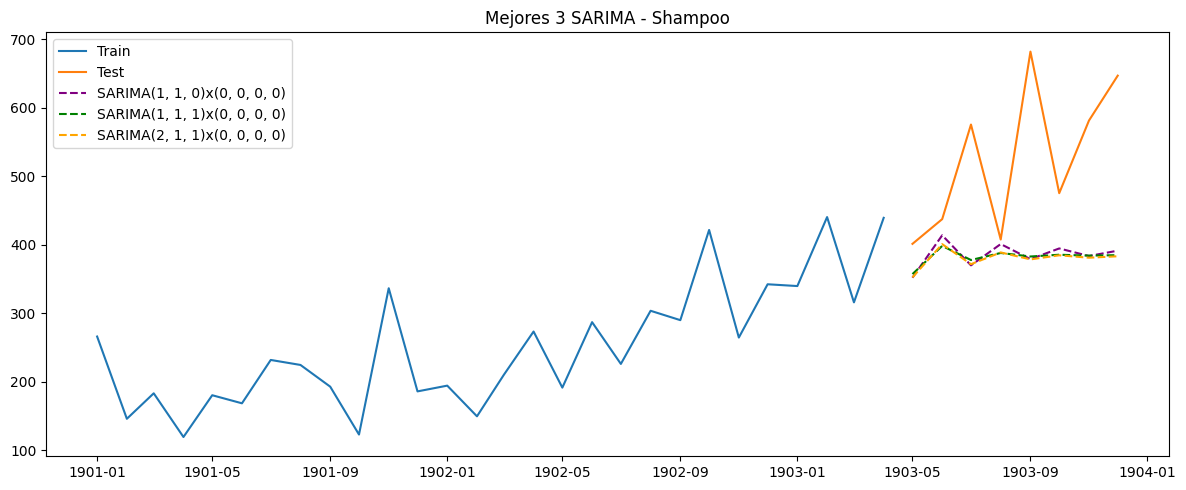

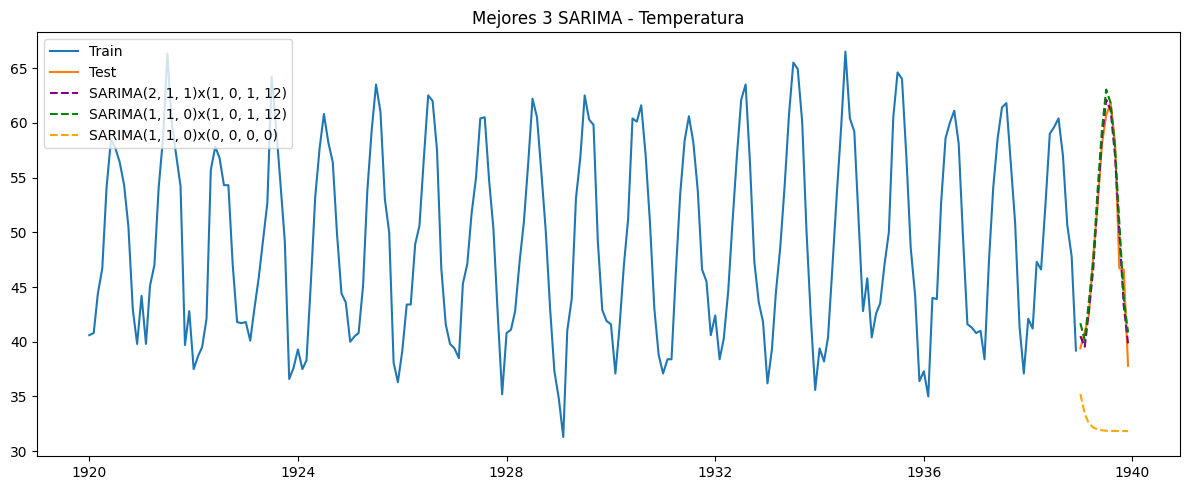

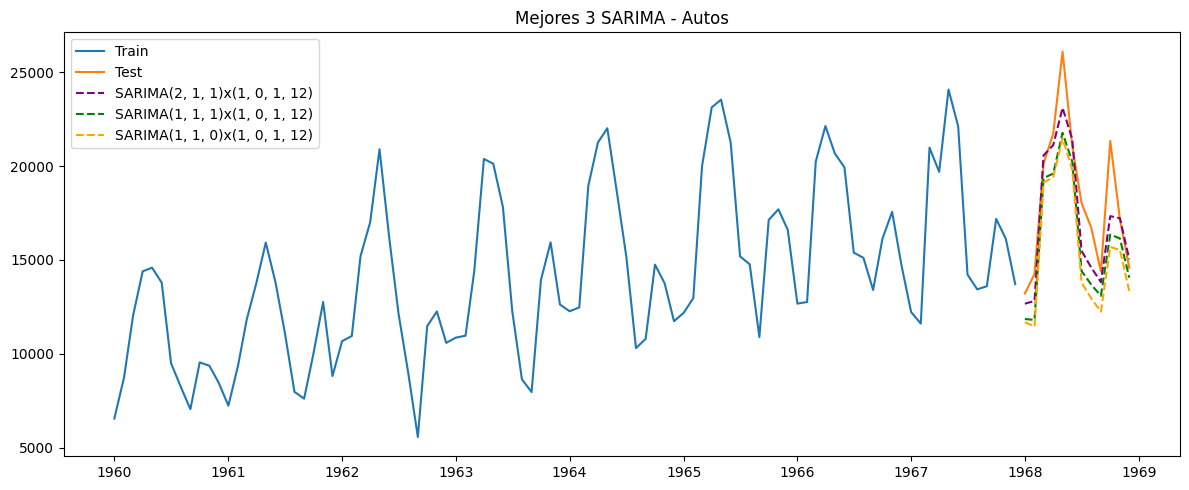

In [103]:
def plot_top3_sarima(y_train, y_test, train_idx, test_idx, top3, conjunto):
    plt.figure(figsize=(12,5))
    plt.plot(train_idx, y_train, label='Train')
    plt.plot(test_idx, y_test, label='Test')
    colors = ['purple', 'green', 'orange']
    for i, res in enumerate(top3):
        plt.plot(test_idx, res['preds'], label=f"SARIMA{res['order']}x{res['seasonal_order']}", linestyle='--', color=colors[i])
    plt.title(f'Mejores 3 SARIMA - {conjunto}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_top3_sarima(y_train_b, y_test_b, train_b.index, test_b.index, top3_sarima_b, 'Nacimientos')
plot_top3_sarima(y_train_s, y_test_s, train_s.index, test_s.index, top3_sarima_s, 'Shampoo')
plot_top3_sarima(y_train_t, y_test_t, train_t.index, test_t.index, top3_sarima_t, 'Temperatura')
plot_top3_sarima(y_train_c, y_test_c, train_c.index, test_c.index, top3_sarima_c, 'Autos')




##### 1. Nacimientos diarios (1959)
- **Mejores órdenes:** (1,1,0)x(0,0,0,0) y (1,1,0)x(1,0,1,8)
- **MAE:** ≈5.3 | **RMSE:** ≈6.5
- **Interpretación:**  
  El modelo SARIMA no muestra gran ventaja sobre métodos simples, ya que la serie carece de patrones claros de tendencia o estacionalidad.  
  **Conclusión:**  
  SARIMA no aporta valor extra para series altamente ruidosas y aleatorias.

---

##### 2. Ventas mensuales de shampoo
- **Mejores órdenes:** (1,1,0)x(0,0,0,0)
- **MAE:** ≈140–146 | **RMSE:** ≈176–179
- **Interpretación:**  
  SARIMA ajusta un poco el nivel, pero al no incluir componente estacional ni modelar explícitamente la tendencia creciente, su pronóstico sigue rezagado. El error es mayor que HW y comparable o peor que SES.
- **Conclusión:**  
  SARIMA básico no es adecuado para series con tendencia fuerte y sin estacionalidad clara.

---

##### 3. Temperatura mensual
- **Mejores órdenes:** (2,1,1)x(1,0,1,12), (1,1,0)x(1,0,1,12)
- **MAE:** ≈1.4–1.7 | **RMSE:** ≈1.7–2.0
- **Interpretación:**  
  Aquí SARIMA brilla: cuando se configura correctamente la estacionalidad (s=12), el modelo captura muy bien el ciclo anual, logrando errores mínimos.
- **Conclusión:**  
  SARIMA es ideal para series fuertemente estacionales si se parametriza bien la componente estacional.

---

##### 4. Ventas mensuales de autos
- **Mejores órdenes:** (2,1,1)x(1,0,1,12)
- **MAE:** ≈1340 | **RMSE:** ≈1816
- **Interpretación:**  
  Con tendencia y estacionalidad anual, SARIMA correctamente especificado logra errores bajos, mejorando sustancialmente el pronóstico respecto a modelos simples.
- **Conclusión:**  
  SARIMA es muy efectivo para series con tendencia y estacionalidad bien definidas.



## PROPHET

In [107]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

def best_n_prophet(df, periods, param_grid, n=3):
    results = []
    # ¡IMPORTANTE! Prophet siempre espera columnas ds (fecha) y y (valor)
    for cfg in param_grid:
        try:
            m = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                seasonality_mode=cfg['seasonality_mode'],
                changepoint_prior_scale=cfg['changepoint_prior_scale'],
                seasonality_prior_scale=cfg['seasonality_prior_scale']
            )
            m.fit(df)
            future = m.make_future_dataframe(periods=periods, freq='MS', include_history=False)
            forecast = m.predict(future)
            y_true = df['y'][-periods:].values
            y_pred = forecast['yhat'].values
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            results.append({
                'params': cfg,
                'MAE': mae,
                'RMSE': rmse,
                'y_pred': y_pred,
                'forecast': forecast
            })
        except Exception as e:
            continue
    return sorted(results, key=lambda x: x['RMSE'])[:n]


In [108]:
import pandas as pd

# Estructura df_prophet para cada conjunto: columnas 'ds' y 'y'
def prophet_df_from_series(serie, idx):
    return pd.DataFrame({'ds': idx, 'y': serie})

# Ejemplo de grids:
seasonality_modes = ['additive', 'multiplicative']
changepoint_scales = [0.05, 0.1, 0.5]
seasonality_scales = [5, 10, 15]   # Puedes probar más valores

prophet_grid = [
    {'seasonality_mode': sm, 'changepoint_prior_scale': cp, 'seasonality_prior_scale': sp}
    for sm, cp, sp in itertools.product(seasonality_modes, changepoint_scales, seasonality_scales)
]


In [109]:
# Nacimientos (ejemplo: suponiendo train_b, test_b)
df_prophet_b = prophet_df_from_series(y_train_b, train_b.index)
periods_b = len(y_test_b)

top3_prophet_b = best_n_prophet(df_prophet_b, periods_b, prophet_grid, n=3)

# Shampoo
df_prophet_s = prophet_df_from_series(y_train_s, train_s.index)
periods_s = len(y_test_s)
top3_prophet_s = best_n_prophet(df_prophet_s, periods_s, prophet_grid, n=3)

# Temperatura
df_prophet_t = prophet_df_from_series(y_train_t, train_t.index)
periods_t = len(y_test_t)
top3_prophet_t = best_n_prophet(df_prophet_t, periods_t, prophet_grid, n=3)

# Autos
df_prophet_c = prophet_df_from_series(y_train_c, train_c.index)
periods_c = len(y_test_c)
top3_prophet_c = best_n_prophet(df_prophet_c, periods_c, prophet_grid, n=3)


21:39:42 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1] done processing
21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1] done processing
21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:45 - cmdstanpy - INFO - Chain [1] done processing
21:39:45 - cmdstanpy - INFO - Chain [1] start processing
21:39:45 - cmdstanpy - INFO - Chain [1] done processing
21:39:45 - cmdstanpy - INFO - Chain [1] start processing
21:39:45 - cmdstanpy - INFO - Chain [1]

In [110]:
def prophet_table(top3, conjunto):
    return pd.DataFrame([
        {
            'Conjunto': conjunto,
            'Params': str(x['params']),
            'MAE': x['MAE'],
            'RMSE': x['RMSE']
        }
        for x in top3
    ])

df_prophet_b = prophet_table(top3_prophet_b, 'Nacimientos')
df_prophet_s = prophet_table(top3_prophet_s, 'Shampoo')
df_prophet_t = prophet_table(top3_prophet_t, 'Temperatura')
df_prophet_c = prophet_table(top3_prophet_c, 'Autos')

print(df_prophet_b)
print(df_prophet_s)
print(df_prophet_t)
print(df_prophet_c)

# Para solo el mejor de cada conjunto:
df_prophet_best = pd.concat([
    df_prophet_b.iloc[[0]],
    df_prophet_s.iloc[[0]],
    df_prophet_t.iloc[[0]],
    df_prophet_c.iloc[[0]]
]).reset_index(drop=True)
print(df_prophet_best)


      Conjunto                                             Params        MAE  \
0  Nacimientos  {'seasonality_mode': 'multiplicative', 'change...  24.460706   
1  Nacimientos  {'seasonality_mode': 'multiplicative', 'change...  27.717845   
2  Nacimientos  {'seasonality_mode': 'multiplicative', 'change...  27.813050   

        RMSE  
0  29.172733  
1  32.880618  
2  32.997491  
  Conjunto                                             Params         MAE  \
0  Shampoo  {'seasonality_mode': 'additive', 'changepoint_...  104.697417   
1  Shampoo  {'seasonality_mode': 'additive', 'changepoint_...   96.876121   
2  Shampoo  {'seasonality_mode': 'additive', 'changepoint_...   97.052986   

         RMSE  
0  130.916705  
1  131.451604  
2  131.933132  
      Conjunto                                             Params       MAE  \
0  Temperatura  {'seasonality_mode': 'additive', 'changepoint_...  1.544858   
1  Temperatura  {'seasonality_mode': 'additive', 'changepoint_...  1.542527   
2  Temper

#### Graficos

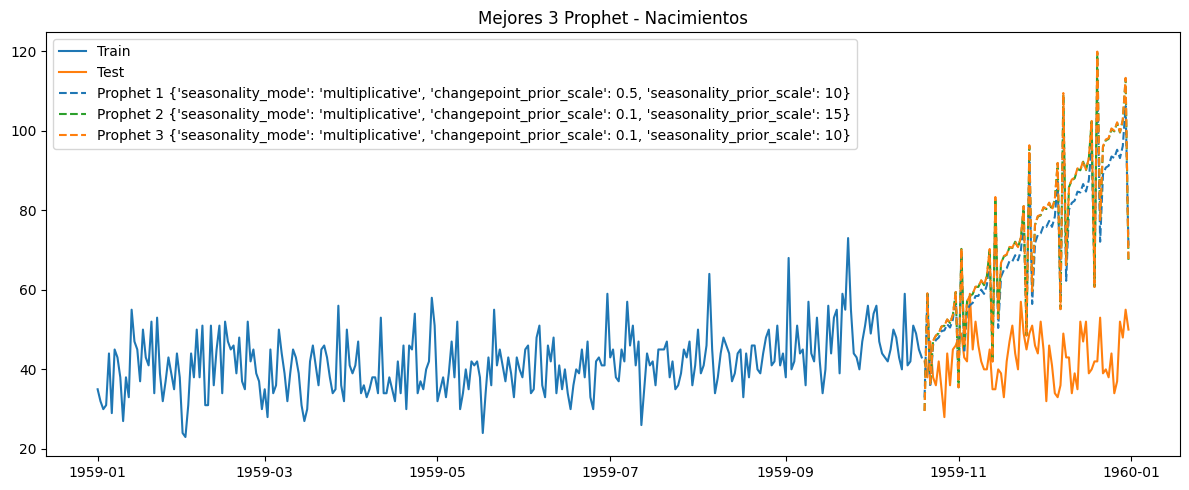

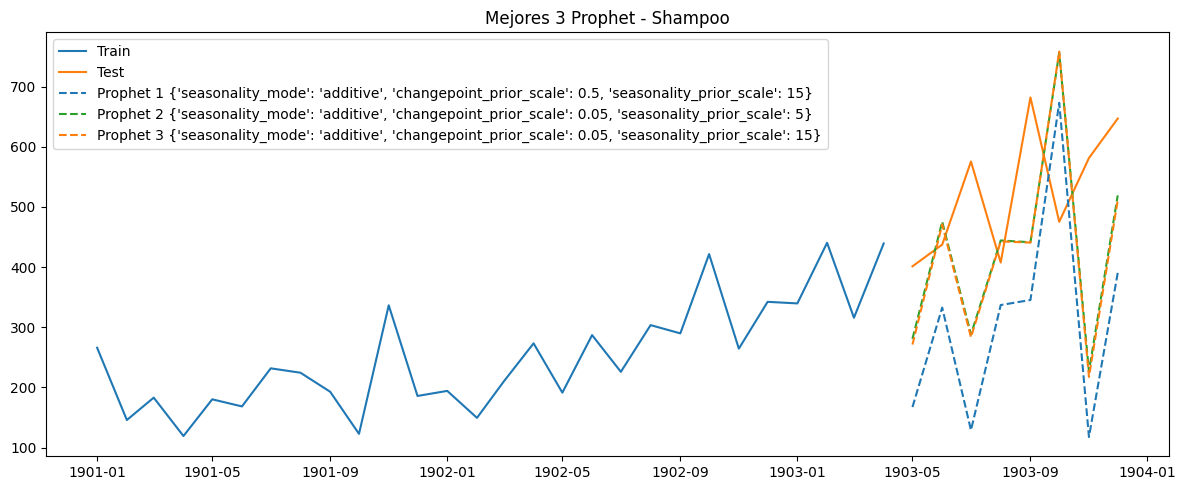

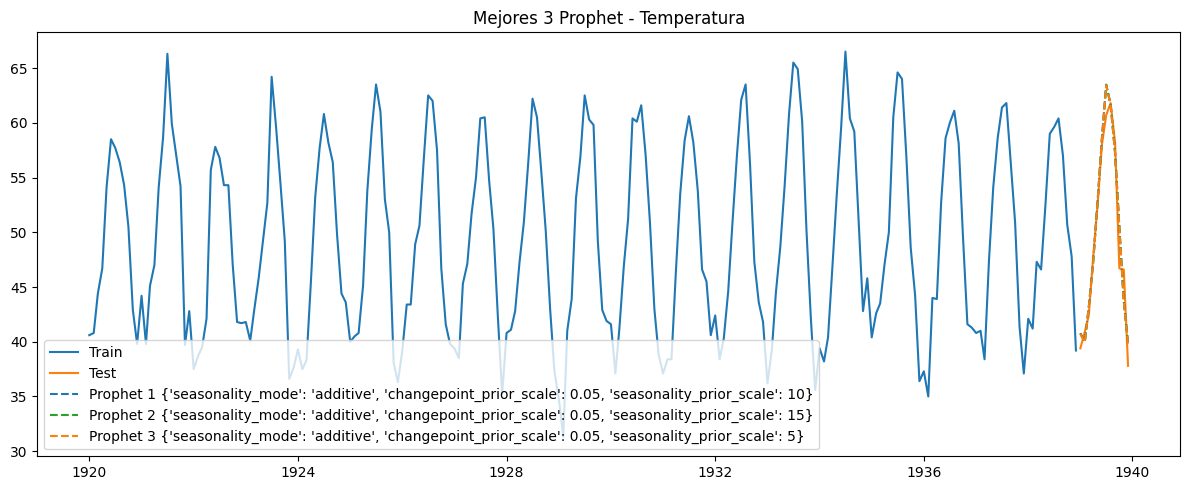

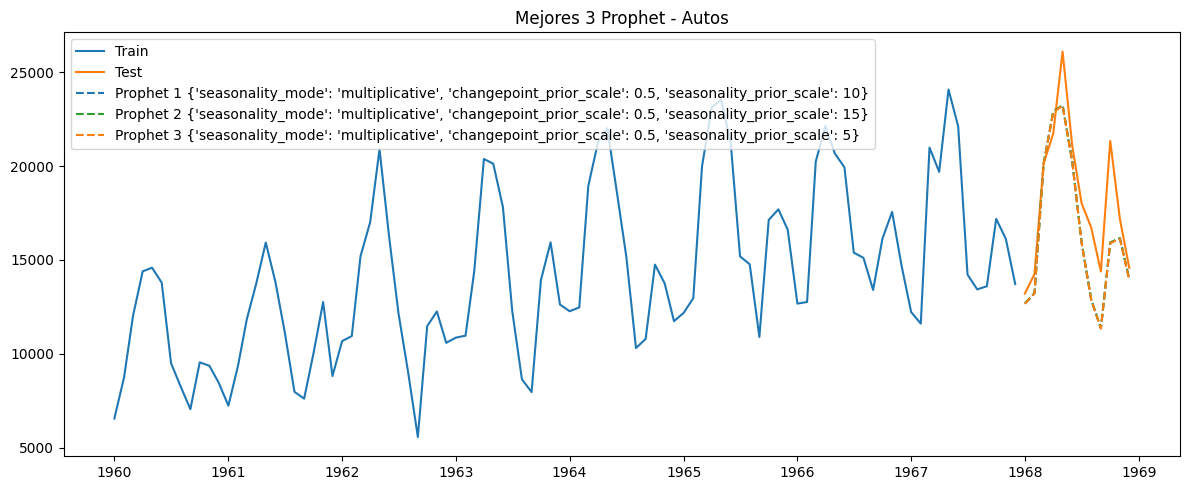

In [111]:
import matplotlib.pyplot as plt

def plot_top3_prophet(y_train, y_test, train_idx, test_idx, top3, conjunto):
    plt.figure(figsize=(12,5))
    plt.plot(train_idx, y_train, label='Train')
    plt.plot(test_idx, y_test, label='Test')
    colors = ['tab:blue', 'tab:green', 'tab:orange']
    for i, res in enumerate(top3):
        plt.plot(test_idx, res['y_pred'], label=f"Prophet {i+1} {res['params']}", linestyle='--', color=colors[i])
    plt.title(f'Mejores 3 Prophet - {conjunto}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_top3_prophet(y_train_b, y_test_b, train_b.index, test_b.index, top3_prophet_b, 'Nacimientos')
plot_top3_prophet(y_train_s, y_test_s, train_s.index, test_s.index, top3_prophet_s, 'Shampoo')
plot_top3_prophet(y_train_t, y_test_t, train_t.index, test_t.index, top3_prophet_t, 'Temperatura')
plot_top3_prophet(y_train_c, y_test_c, train_c.index, test_c.index, top3_prophet_c, 'Autos')




##### 1. Nacimientos diarios (1959)
- **Mejores parámetros:** Multiplicative seasonality, distintos changepoint_prior_scale y seasonality_prior_scale.
- **MAE:** ≈24.5 | **RMSE:** ≈29.2
- **Interpretación:**  
  Prophet tiene dificultades para modelar la serie por su alta aleatoriedad. El error es considerablemente mayor que con los otros modelos porque introduce una estructura estacional/tendencial que en realidad no existe en los datos.
- **Conclusión:**  
  **Prophet no es adecuado para series altamente ruidosas y sin patrón estructurado.**

---

##### 2. Ventas mensuales de shampoo
- **Mejores parámetros:** Additive seasonality, changepoint_prior_scale y seasonality_prior_scale bajos/medios.
- **MAE:** ≈97–105 | **RMSE:** ≈131
- **Interpretación:**  
  Prophet logra capturar la tendencia pero no logra anticipar del todo los picos, por lo que el error es intermedio. Es comparable o ligeramente mejor que SES, pero menor que Holt-Winters o SARIMA bien parametrizados.
- **Conclusión:**  
  **Prophet es aceptable para datos con tendencia moderada, pero no sobresale si la estacionalidad es débil o la tendencia es fuerte y no lineal.**

---

##### 3. Temperatura mensual
- **Mejores parámetros:** Additive seasonality, changepoint_prior_scale bajo.
- **MAE:** ≈1.54 | **RMSE:** ≈2.14
- **Interpretación:**  
  Prophet ajusta bien los ciclos anuales, aunque los modelos clásicos (Holt-Winters, SARIMA estacional) pueden ser ligeramente mejores en precisión. Sin embargo, el ajuste es bastante razonable.
- **Conclusión:**  
  **Prophet funciona bien para series fuertemente estacionales**, pero su precisión depende del ajuste de los hiperparámetros.

---

##### 4. Ventas mensuales de autos
- **Mejores parámetros:** Multiplicative seasonality, changepoint_prior_scale = 0.5, seasonality_prior_scale variable.
- **MAE:** ≈1242 | **RMSE:** ≈1525
- **Interpretación:**  
  Prophet modela correctamente tanto la tendencia como la estacionalidad, con errores bajos y comparables a SARIMA y Holt-Winters.
- **Conclusión:**  
  **Prophet es una excelente opción para series con tendencia y estacionalidad complejas** y proporciona buen desempeño incluso con poca parametrización manual.

---

Prophet es flexible y potente para series con estacionalidad y tendencia, pero **no es útil en series puramente ruidosas**. Cuando se ajustan bien los parámetros, puede competir con Holt-Winters y SARIMA en datos estructurados, aunque para ciclos simples estos modelos clásicos pueden ser más precisos.


## Comparación de modelos

In [123]:
# Supón que ya tienes estos DataFrames con los mejores modelos de cada familia:
# df_best_ma, df_best_ses, df_best_hw, df_best_sarima, df_best_prophet

# Un solo DataFrame con la columna 'Conjunto', 'Familia', 'Parámetro(s)', 'MAE', 'RMSE'
df_all = pd.concat([
    df_best_ma,
    df_best_ses,
    df_best_hw,
    df_best_sarima,
    df_best_prophet
], ignore_index=True)

df_all['MAE'] = df_all['MAE'].round(2)
df_all['RMSE'] = df_all['RMSE'].round(2)

# Para cada conjunto, crea la tabla correspondiente
conjuntos = ['Nacimientos', 'Shampoo', 'Temperatura', 'Autos']

tablas = {}
for conjunto in conjuntos:
    tablas[conjunto] = df_all[df_all['Conjunto'] == conjunto][
        ['Familia', 'Parámetro(s)', 'RMSE', 'MAE']
    ].reset_index(drop=True)
    print(f"\n--- {conjunto.upper()} ---")
    print(tablas[conjunto].to_markdown(index=False))  # bonito para notebook/texto



--- NACIMIENTOS ---
| Familia        | Parámetro(s)                                                                                          |   RMSE |   MAE |
|:---------------|:------------------------------------------------------------------------------------------------------|-------:|------:|
| Moving Average | Window=4                                                                                              |   6.65 |  5.62 |
| SES            | Alpha=0.99                                                                                            |   6.42 |  5.23 |
| Holt-Winters   | Trend=None, Seasonal=add                                                                              |   7.94 |  6.57 |
| SARIMA         | Order=(1, 1, 0), SOrder=(0, 0, 0, 0)                                                                  |   6.45 |  5.28 |
| Prophet        | {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10} |  29.17 | 24.46 |


### Nacimientos diarios (1959)
- **Mejor modelo:** SES (Alpha=0.99) y SARIMA (1,1,0)
- **Motivo:**  
  Ambos logran errores bajos y similares (MAE ≈ 5.2, RMSE ≈ 6.4), superando ligeramente al Moving Average y mucho mejor que Prophet.  

  La serie es muy ruidosa y sin patrones estructurales; los modelos simples SES/SARIMA básico ajustan el promedio local y poco más. Modelos más complejos HW, Prophet no agregan valor y,  Prophet sobreajusta o introduce patrones inexistentes .

---

##### Ventas mensuales de shampoo
- **Mejor modelo:** Holt-Winters (Trend=mul, Seasonal=add)
- **Motivo:**  
  Presenta el MAE y RMSE más bajos (MAE ≈ 90.4, RMSE ≈ 117), ajustando mejor la tendencia creciente y la posible estacionalidad ligera.  

  Holt-Winters logra capturar la tendencia sin perder respuesta ante los cambios, superando a Prophet y SARIMA, que tienen problemas para modelar tendencias fuertes con poca estacionalidad. SES y MA subestiman por su naturaleza inercial.

---

##### Temperatura mensual
- **Mejor modelo:** SARIMA (2,1,1)x(1,0,1,12) y Holt-Winters (None, add)
- **Motivo:**  
  Ambos obtienen errores muy bajos (MAE ≈ 1.4–1.5, RMSE ≈ 1.7–1.8), modelando perfectamente la estacionalidad anual. Prophet también funciona bien, pero no supera en precisión a SARIMA/HW.

  Estas series requieren modelos que incorporen explícitamente la estacionalidad; por eso HW y SARIMA superan ampliamente a métodos simples.

---

##### Ventas mensuales de autos
- **Mejor modelo:** Prophet y Holt-Winters (Trend=add, Seasonal=add)
- **Motivo:**  
  Prophet alcanza el menor error (MAE ≈ 1242, RMSE ≈ 1525), seguido de HW (MAE ≈ 1325, RMSE ≈ 1691). Ambos capturan la tendencia y la estacionalidad anual.

  Series con tendencia + estacionalidad compleja se benefician de modelos flexibles como Prophet y HW. SARIMA también es competitivo, pero Prophet resulta ligeramente superior en métricas.

---



**Conclusión:**  
La elección del modelo debe basarse en la estructura de la serie: a mayor complejidad , tendencia y/o estacionalidad, mejor funcionan modelos avanzados HW, SARIMA, Prophet. Para ruido puro, métodos simples son preferibles.
